In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.datasets import fetch_openml, load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from wisard.encoders import ThermometerEncoder, encode_dataset
from wisard.wisard import WiSARD
from wisard.utils import untie
from wisard.optimize import find_best_bleach_bayesian, find_best_bleach_bin_search

from keras.datasets import mnist, cifar10, fashion_mnist

%matplotlib inline

2022-08-04 15:55:26.359598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-04 15:55:26.359685: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def pick_a_sample(target: int, X, y, shape: tuple):
    return next((digit for (digit, label) in zip(X, y)
                 if int(label) == int(target))).reshape(shape)


def display_samples(X,
                    y,
                    rows: int = 2,
                    columns: int = 5,
                    figsize=(16, 8),
                    vmin: float = None,
                    vmax: float = None,
                    shape: tuple = (28, 28),
                    cmap: str = "gray"):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for i in range(rows):
        for j in range(columns):
            im = axs[i, j].imshow(
                pick_a_sample(target=columns * i + j, X=X, y=y, shape=shape),
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
            )
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
            if vmin is None or vmax is None:
                fig.colorbar(im, ax=axs[i, j], shrink=0.6)
    if vmin is not None and vmax is not None:
        fig.colorbar(im, ax=axs[:, 4], location="right", shrink=0.6)
    plt.show()

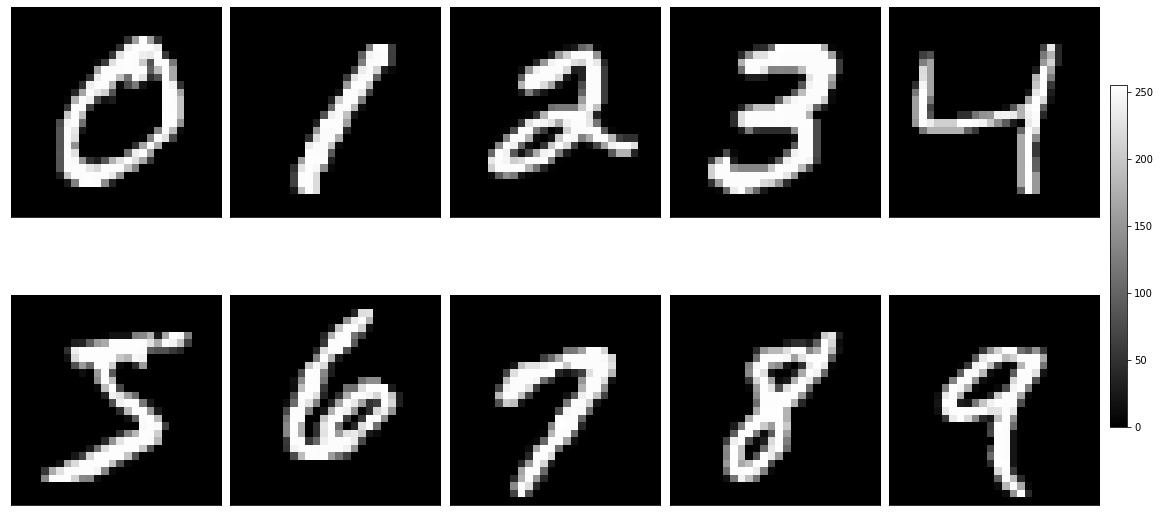

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
display_samples(x_train, y_train, vmin=0, vmax=255)

In [5]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=16)
x_train = encode_dataset(thermometer, x_train)
x_test = encode_dataset(thermometer, x_test)

Encoding dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 7657.72it/s]


# Creating wisard

In [6]:
shared_rand_vals = True  # not used...
input_size = x_train[0].size
num_classes = 10
tuple_size = 16
unit_entries = 1  # Only used for BloomFilter
unit_hashes = 1  # Only used for BloomFilter
input_idxs = np.random.shuffle(np.arange(input_size))  # Order to select elements
# input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()
randomize = False  # Randomize selection order?

In [7]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False,
)

In [8]:
model.fit(x_train, y_train)

Training model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [01:01<00:00, 969.61it/s]


In [9]:
best_bleach = find_best_bleach_bayesian(model,
                                        X=x_test,
                                        y=y_test,
                                        min_bleach=1,
                                        max_bleach=model.max_bleach())

|   iter    |  target   |  bleach   |
-------------------------------------
| 1         | 0.4304    | 869.9     |
| 2         | 0.5086    | 709.9     |
| 3         | 0.1135    | 6.579e+03 |
| 4         | 0.8044    | 151.0     |
| 5         | 0.8037    | 152.1     |
| 6         | 0.1174    | 3.744e+03 |
| 7         | 0.9039    | 1.0       |
| 8         | 0.9039    | 1.0       |
| 9         | 0.9039    | 1.85      |
| 10        | 0.9039    | 1.85      |
| 11        | 0.9039    | 1.85      |
| 12        | 0.9039    | 1.85      |
| 13        | 0.9039    | 1.85      |


In [10]:
print(best_bleach)

1.0


In [11]:
best_bleach = find_best_bleach_bin_search(model,
                                          X=x_test,
                                          y=y_test,
                                          min_bleach=1,
                                          max_bleach=model.max_bleach())

Testing with bleach=1686


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1698305.06it/s]


[b=1686] Accuracy=0.203, ties=2563
Testing with bleach=3371


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1767734.65it/s]


[b=3371] Accuracy=0.126, ties=1141
Testing with bleach=5056


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1743993.35it/s]


[b=5056] Accuracy=0.114, ties=273
Testing with bleach=844


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1769972.57it/s]


[b=844] Accuracy=0.440, ties=780
Testing with bleach=1686
[b=1686] Accuracy=0.203
Testing with bleach=2528


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1641092.42it/s]


[b=2528] Accuracy=0.155, ties=1969
Testing with bleach=423


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1347134.74it/s]


[b=423] Accuracy=0.666, ties=220
Testing with bleach=844
[b=844] Accuracy=0.440
Testing with bleach=1265


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1719399.85it/s]


[b=1265] Accuracy=0.284, ties=2148
Testing with bleach=213


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1535587.61it/s]


[b=213] Accuracy=0.769, ties=105
Testing with bleach=423
[b=423] Accuracy=0.666
Testing with bleach=633


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1687034.03it/s]


[b=633] Accuracy=0.549, ties=401
Testing with bleach=108


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1676782.60it/s]


[b=108] Accuracy=0.831, ties=69
Testing with bleach=213
[b=213] Accuracy=0.769
Testing with bleach=318


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1697617.68it/s]


[b=318] Accuracy=0.726, ties=171
Testing with bleach=56


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1683107.54it/s]


[b=56] Accuracy=0.874, ties=37
Testing with bleach=108
[b=108] Accuracy=0.831
Testing with bleach=160


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1669308.29it/s]


[b=160] Accuracy=0.801, ties=74
Testing with bleach=30


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1593338.40it/s]


[b=30] Accuracy=0.902, ties=30
Testing with bleach=56
[b=56] Accuracy=0.874
Testing with bleach=82


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1558815.18it/s]


[b=82] Accuracy=0.849, ties=48
Testing with bleach=17


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1619797.64it/s]


[b=17] Accuracy=0.916, ties=31
Testing with bleach=30
[b=30] Accuracy=0.902
Testing with bleach=43


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1675911.62it/s]


[b=43] Accuracy=0.888, ties=32
Testing with bleach=11


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1508579.65it/s]


[b=11] Accuracy=0.921, ties=35
Testing with bleach=17
[b=17] Accuracy=0.916
Testing with bleach=23


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1614311.45it/s]


[b=23] Accuracy=0.910, ties=32
Testing with bleach=8


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1577517.68it/s]


[b=8] Accuracy=0.926, ties=37
Testing with bleach=11
[b=11] Accuracy=0.921
Testing with bleach=14


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1713079.56it/s]


[b=14] Accuracy=0.919, ties=28
Testing with bleach=7


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1657434.60it/s]


[b=7] Accuracy=0.926, ties=36
Testing with bleach=8
[b=8] Accuracy=0.926
Testing with bleach=9


Untieing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 1658745.55it/s]

[b=9] Accuracy=0.924, ties=30
Best bleach: 8....


In [12]:
print(best_bleach)

8
